__Análise de dados Docking - 2 Um tratamento estatístico__

Diferente da parte 1, aqui vamos ser mais dinâmicos. Iremos utilizar formas mais diretas de realizar as operações com os dados. Além de trazer um tratamento mais estatístico para os dados, buscando porcentagem de ocupação de energia, média, mediana e desvio-pad, além de outros tramentos.

Caso não tenha alguma biblioteca

In [1]:
'''
!pip install heatmapz
!pip install plotly
'''

'\n!pip install heatmapz\n!pip install plotly\n'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from heatmap import heatmap, corrplot
rcParams['figure.figsize'] = 7,7 
sns.set(color_codes=True, font_scale=1.2)

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
#Abrir gráficos plotly em uma nova guia
#pio.renderers.default = 'browser'
fig=go.Figure()

%matplotlib inline  

Esse algoritmo analisa uma pasta com arquivos pdbqt gerados por docking com o vina e as transforma em um dataframe com a posição do centro de mass, valor do RMSD e energia.

Para esse notebook funcionar corretamente, você precisa instalar bibliotecas como, rmsd, periodictable, numpy e pandas.

Qualquer questão escreva para rafael.pleite@usp.br

Funções para extrair os dados dos arquivos .pdbqt

In [9]:
def load(path, name):
    pre_data = ''
    with open(os.path.join(path, name)) as fp:
        pre_data = fp.read().split('MODEL')
        del pre_data[0]
        fp.close()
    return pre_data

        
def take_position(every_result): #receive a vina result and gives back a array with (energy, array(atom_name, x, y, z)) position of every atom
    array = []
    energy = every_result.split('\n')[1].split()[3]
    for i in every_result.split('\n'):
        if 'HETATM' in i:
            array.append(list(''.join(p for p in i.split()[2] if not p.isdigit())) + i.split()[4:7])
    return energy, np.array(array)

def CM(array): #receive an array with (atom_name, x, y, z) and gives back the center of mass position
    global elements
    total_mass = np.sum([elements[x] for x in array[:,0]])
    x = np.array([elements[x[0]]*float(x[1]) for x in array[:,:2]], dtype=float)
    y = np.array([elements[x[0]]*float(x[1]) for x in array[:,[0,2]]], dtype=float)
    z = np.array([elements[x[0]]*float(x[1]) for x in array[:,[0,3]]], dtype=float)
    return np.array([sum(x)/total_mass, sum(y)/total_mass, sum(z)/total_mass], dtype=str)
    

def make_array(data, name, V): #recive data with N results processed by load() and name, gives back array(name, count, x, y, z, rmsd, energy) 
    pos_data = np.chararray([len(data), 7], 32, True)
    pos_data[:,0] = np.array([name.split('.pdbqt')[0]]*len(data), dtype=str)
    pos_data[:,1] = np.array([x for x in range(1, len(data)+1)], dtype=str)
    for i, ival in enumerate(data):
        result = take_position(ival)
        pos_data[i, 5] = result[0]
        pos_data[i, 2:5] = CM(result[1])
        W = np.array([x for x in result[1] if (x[0] != 'H')])[:,1:]
        global SHOULD_CALCULATE_RMSD
        if SHOULD_CALCULATE_RMSD: RMSD_val = RMSD(V, W)
        else: RMSD_val = False
        if RMSD_val != False: pos_data[i, 6] = RMSD_val
        else:
            if V.shape == W.shape and np.any(V == W): 
                pos_data[i, 6] = 0
            else:
                pos_data[i, 6] = 'CANNOT CALCULATE RMSD'
    return pos_data
                
def RMSD(V, W):
    global SHOULD_CALCULATE_RMSD
    if V.shape != W.shape or not SHOULD_CALCULATE_RMSD: 
        return False #Cannot calculate RMSD because number os atoms of V is different the number os atoms W
    diff = np.array(V, dtype=float) - np.array(W, dtype=float)
    return np.sqrt((diff * diff).sum() / len(V))

Essa parte é vital para o funcionamente correto do código.

Abaixo entre com o caminho da pasta com os arquivos .pdbqt.

In [10]:
SHOULD_TAKE_SUBFOLDERS = False #Should verify subfolders of variable path to find others .pdbqt files.
SHOULD_CALCULATE_RMSD = True #Desire calculate RMSD?
path = r'C:\Users\Rafael\Nanobio\Nsp15\pdbqt'

Entre aqui com o nome do arquivo de referencial, isto é, o seu melhor resultado para ser o referencial do sistema que calcula o RMSD

In [19]:
referential = 'CN289.pdbqt'

In [20]:
elements = {'H': 1.00797, 'He': 4.0026, 'Li': 6.941, 'Be': 9.01218, 'B': 10.81, 'C': 12.011, 'N': 14.0067, 'O': 15.9994, 'F': 18.998403, 'Ne': 20.179, 'Na': 22.98977, 'Mg': 24.305, 'Al': 26.98154, 'Si': 28.0855, 'P': 30.97376, 'S': 32.06, 'Cl': 35.453, 'Ar': 39.948, 'K': 39.0983, 'Ca': 40.08, 'Sc': 44.9559, 'Ti': 47.9, 'V': 50.9415, 'Cr': 51.996, 'Mn': 54.938, 'Fe': 55.847, 'Co': 58.9332, 'Ni': 58.7, 'Cu': 63.546, 'Zn': 65.38, 'Ga': 69.72, 'Ge': 72.59, 'As': 74.9216, 'Se': 78.96, 'Br': 79.904, 'Kr': 83.8, 'Rb': 85.4678, 'Sr': 87.62, 'Y': 88.9059, 'Zr': 91.22, 'Nb': 92.9064, 'Mo': 95.94, 'Tc': 98, 'Ru': 101.07, 'Rh': 102.9055, 'Pd': 106.4, 'Ag': 107.868, 'Cd': 112.41, 'In': 114.82, 'Sn': 118.69, 'Sb': 121.75, 'Te': 127.6, 'I': 126.9045, 'Xe': 131.3, 'Cs': 132.9054, 'Ba': 137.33, 'La': 138.9055, 'Ce': 140.12, 'Pr': 140.9077, 'Nd': 144.24, 'Pm': 145, 'Sm': 150.4, 'Eu': 151.96, 'Gd': 157.25, 'Tb': 158.9254, 'Dy': 162.5, 'Ho': 164.9304, 'Er': 167.26, 'Tm': 168.9342, 'Yb': 173.04, 'Lu': 174.967, 'Hf': 178.49, 'Ta': 180.9479, 'W': 183.85, 'Re': 186.207, 'Os': 190.2, 'Ir': 192.22, 'Pt': 195.09, 'Au': 196.9665, 'Hg': 200.59, 'Tl': 204.37, 'Pb': 207.2, 'Bi': 208.9804, 'Po': 209, 'At': 210, 'Rn': 222, 'Fr': 223, 'Ra': 226.0254, 'Ac': 227.0278, 'Th': 232.0381, 'Pa': 231.0359, 'U': 238.029, 'Np': 237.0482, 'Pu': 242, 'Am': 243, 'Cm': 247}

#V is a array (N,D) dimensions with position of each point of referential result
V = take_position(load(path, referential)[0])[1]
V = np.array([x for x in V if (x[0] != 'H')])[:,1:]


dataset = np.chararray((0,7), 32, True)
for root, directories, files in os.walk(path, topdown=False):
    if SHOULD_TAKE_SUBFOLDERS or root == path:
        for name in files:
            if name.find('.pdbqt') != 1:
                add = make_array(load(path, name), name, V)
                dataset = np.append(dataset, add).reshape(dataset.shape[0] + add.shape[0], 7)
if 'CANNOT CALCULATE RMSD' not in dataset[:, 6]:
    df = pd.DataFrame(data=dataset, columns=('Name', 'Count', 'x', 'y', 'z', 'Energy', 'RMSD'))
    df[['x','y','z', 'Energy', 'RMSD']] = df[['x','y','z', 'Energy', 'RMSD']].astype(float)
else: 
    df = pd.DataFrame(data=dataset[:,:6], columns=('Name', 'Count', 'x', 'y', 'z', 'Energy'))
    df[['x','y','z', 'Energy']] = df[['x','y','z', 'Energy']].astype(float)

Informações sobre o DataFrame.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    342 non-null    object 
 1   Count   342 non-null    object 
 2   x       342 non-null    float64
 3   y       342 non-null    float64
 4   z       342 non-null    float64
 5   Energy  342 non-null    float64
dtypes: float64(4), object(2)
memory usage: 16.2+ KB


In [24]:
df = df[df['Energy'] <= 0]
df.sort_values(by=['Energy'])

,Name,Count,x,y,z,Energy
144,CN289,1,0.0,-63.317351,53.519690,-9.6
135,CN288,1,0.0,-63.604122,53.408756,-9.6
136,CN288,2,0.0,-60.301456,49.997688,-9.1
137,CN288,3,0.0,-65.152680,53.180428,-9.0
138,CN288,4,0.0,-63.506244,53.442669,-9.0
...,...,...,...,...,...,...
332,CN394,9,0.0,-66.542931,42.551572,-5.2
71,CN277,9,0.0,-43.639788,65.353969,-5.2
250,CN340,8,0.0,-60.208872,55.107855,-5.2
251,CN340,9,0.0,-59.213540,54.722598,-5.2


__Gráficos__

Gráfico de correlação

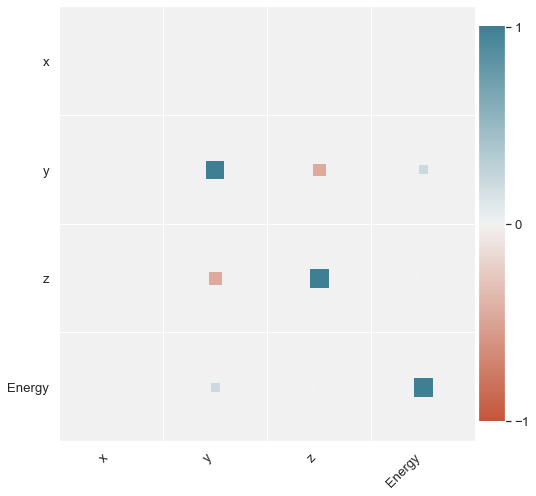

In [31]:
plt.figure(figsize=(8, 8))
corrplot(df.corr(), size_scale=300)
#plt.savefig('Correlacao'+'.png', dpi=600)

Aqui, vamos trabalhar com clusters para energias <=-7.5, <=-8.0, <=-8.5.

Gráfico da distribuição espacial dos pontos nos intervalos. Fique avontade para modificar o termo (abs(i) * 3), pois ele modifica o tamanho dos pontos do gráfico.

In [61]:
#Caso deseje visualizar a distribuição, rode.

for i in [-7., -8., -9.]:
    print('Energia <= ', i, ' kcal/mol')
    siz = df[df['Energy'] <= i].drop(['Name','Count'], axis=1).apply(abs).apply(lambda x: x**(abs(i) * 3) )['Energy']
    fig = px.scatter_3d(df[df['Energy'] <=i], x = 'x', text='Name',  y = 'y',  z = 'z', color = 'Energy', size= siz)
    fig.show()


Energia <=  -7.0  kcal/mol


Energia <=  -8.0  kcal/mol


Energia <=  -9.0  kcal/mol


__CLUSTERIZAÇÃO__

Daqui para frente iremos trabalhar com a clusterização dos dados coletados. Fique a vontade para modificar os parâmetros dos algoritmos de clusterização da forma que achar melhor.


__Vamos tentar usar o DBSCAN__

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler



Para energia de -7.0 kcal/mol
              mean  median       std  Ocupação %
Cluster                                        
-1      -7.660000    -7.6  0.719722    3.268476
 0      -7.695522    -7.5  0.601610   88.001365
 1      -7.280000    -7.1  0.303315    3.106332
 2      -7.322222    -7.2  0.389801    5.623827


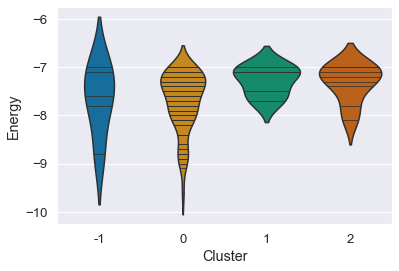

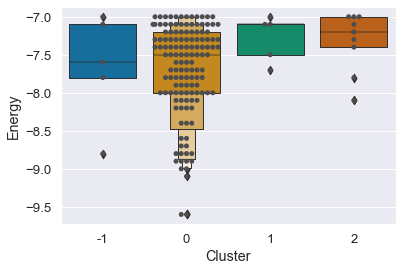



Para energia de -8.0 kcal/mol
           mean  median       std  Ocupação %
Cluster                                     
-1      -8.450   -8.45  0.494975    4.759223
 0      -8.455   -8.30  0.459626   95.240777


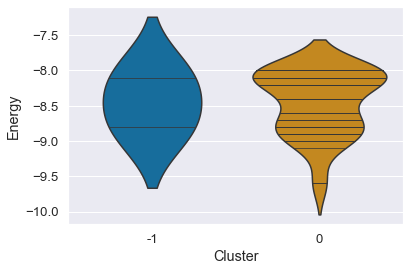

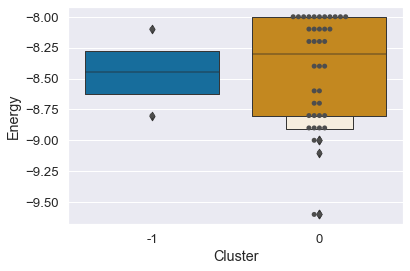



Para energia de -9.0 kcal/mol
          mean  median      std  Ocupação %
Cluster                                   
-1       -9.1    -9.1      NaN   19.654428
 0       -9.3    -9.3  0.34641   80.345572


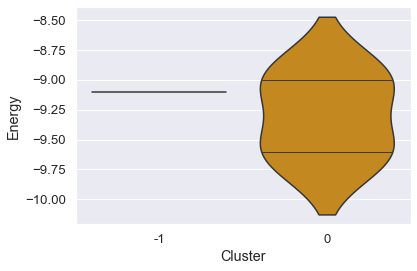

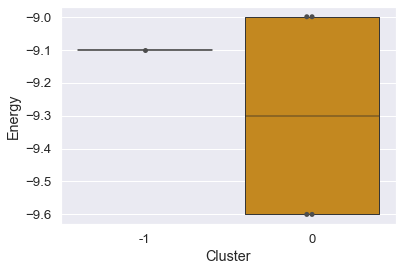

In [60]:
valores_busca = [-7., -8., -9.]
for i in valores_busca:
    #CLUSTERIZACAO
    clustering = DBSCAN(eps= 3, min_samples = 4).fit(df[df['Energy'] <= i].drop(['Name', 'Count', 'Energy'], axis=1))
    df_p = df[df['Energy'] <= i].copy()
    df_p['Cluster'] = clustering.labels_
    
    #IMPLEMENTAR A MÉDIA DO RMSD TAMBÉM!!!
    pc = df_p[['Cluster', 'Energy']].groupby(by=['Cluster']).agg([np.mean, np.median, np.std, np.sum])['Energy']
    pc['Ocupação %'] = pc['sum'].apply(lambda x: abs(x/ pc['sum'].sum() *100))
    pc = pc.drop('sum', axis=1)
    
    siz = df_p.drop(['Name','Count'], axis=1).apply(abs).apply(lambda x: x**(abs(i) * 3) )['Energy']
    fig = px.scatter_3d(df_p, x = 'x',  y = 'y',  z = 'z', text='Name', color = 'Cluster', size=siz, title=f'Cluster para {i} (kcal/mol) com o Luteoin na PLPro de SARS-CoV-2')
    fig.show()
    print(f'\n\nPara energia de {i} kcal/mol\n', pc)
    
    
    #Gráficos
    sns.violinplot(x='Cluster', y='Energy', data=df_p, palette="colorblind", split=True, inner="stick")
    plt.show()
    sns.boxenplot(x='Cluster', y='Energy', data=df_p, palette="colorblind")
    sns.swarmplot(x='Cluster', y='Energy', data=df_p, color='.3')
    plt.show()

CN288 e CN289 são o dados com melhores resultados para uma análise completa.